# Traffic Detector

Rubén Perdomo, Nerea Valido

Universidad de Las Palmas de Gran Canaria

### Introducción
En este trabajo se presenta un sistema para detectar y contar vehículos en un video utilizando la librería OpenCV. El método se basa en comparar el video con una imagen de fondo para detectar las zonas donde hay movimiento. Después, se aplican algunos filtros para eliminar el ruido y se identifican los objetos en movimiento. A partir de estos objetos se calcula su posición y se realiza el conteo cuando cruzan una línea virtual definida en la imagen.


Empezamos instalando las librerías que necesitamos para realizar el proyecto. En este caso necesitaremos OpenCV para todo lo relevante a visión por computador y Numpy para cambiar el formato de ciertos números para resolver algunas operaciones con facilidad.

In [ ]:
!pip install opencv-python numpy

### Creación del fondo estático

Creamos un fondo para restarlo al video y tener como resultado los cambios que ocurren en el video.

Para hacer esto, leemos el video del que queremos sacar el fondo frame por frame y los guardamos junto con un contador. Con estas dos variables hacemos la media de todas las imágenes, cuyo resultado será una imagen promedio que será esencialmente un fondo.

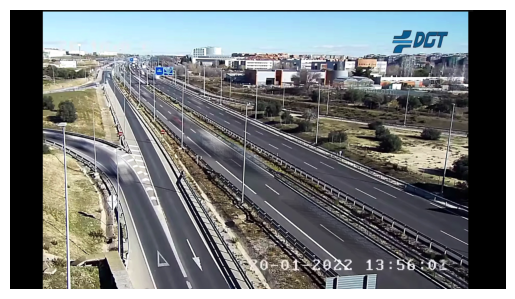

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

video = cv2.VideoCapture("trafico.mp4")
accumulated_frame = None
frame_count = 0

while True:
    ret, frame = video.read()
    if not ret:
        break

    cv2.imshow('Video', frame)

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    # Convierte el frame a float para realizar la acumulación
    frame_float = frame.astype(np.float32)

    if accumulated_frame is None:
        accumulated_frame = frame_float
    
    accumulated_frame += frame_float
    frame_count += 1

video.release()

background = accumulated_frame / frame_count # Media

# Convierte de nuevo a uint8 para mostrar/guardar
background_uint8 = cv2.convertScaleAbs(background)

# Muestra el fondo promedio
# cv2.imshow('Fondo Promedio', background_uint8)
img = cv2.cvtColor(background_uint8, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

# cv2.imwrite('fondo_estatico.jpg', background_uint8)
cv2.waitKey(0)
cv2.destroyAllWindows()

### BINARIZACIÓN DEL VIDEO Y CONTEO DE VEHÍCULOS
Para realizar este apartado, requerimos de una serie de variables para el conteo de vehículos. Para nuestra implementación hemos optado por crear una línea que divida la pantalla en dos para que cuando un vehículo detectado pase por dicha línea sea contado. 

In [ ]:
fondo = cv2.imread("fondo_estatico.jpg") #Leer la imagen del fondo.
fondo_BW = cv2.cvtColor(fondo, cv2.COLOR_BGR2GRAY) #Pasar el fondo a blanco y negro.

video = cv2.VideoCapture("trafico.mp4")
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

# -------------------- VARIABLES PARA EL CONTADOR --------------------
contador = 0
linea_conteo = frame_height // 2   # Línea horizontal de conteo (invisible)
offset = 10                        # Margen de tolerancia al cruzar la línea
bloqueados = []                    # Lista de puntos bloqueados temporalmente
tiempo_bloqueo = 15                # Cuántos frames permanece bloqueado un punto

# Definir línea diagonal de conteo
p1a = (100, frame_height - 100)      # punto inicial (abajo izquierda)
p1b = (frame_width - 100, 100)       # punto final (arriba derecha)
# Definir línea 2 (fin)
p2a = (200, frame_height - 50)
p2b = (frame_width - 100, 200)

# Calcular coeficientes de ambas líneas (Ax + By + C = 0)
def coef_linea(p1, p2):
    A = p1[1] - p2[1]
    B = p2[0] - p1[0]
    C = p1[0]*p2[1] - p2[0]*p1[1]
    return A, B, C

A1, B1, C1 = coef_linea(p1a, p1b)
A2, B2, C2 = coef_linea(p2a, p2b)

Aquí finalmente estaría el código principal; un bucle while en el que se hacen las operaciones de binarización, aplicación de operaciones morfológicas para reducir el ruido, la detección de blobs y el conteo de los vehículos.

In [ ]:
while True:
    ret, frame = video.read()
    if not ret:
        break

    # Convertir el frame a escala de grises
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Restar el fondo al frame actual (diferencia absoluta)
    diff = cv2.absdiff(frame_gray, fondo_BW)

    # Aplicar un umbral para detectar movimiento (valores mayores a 30, por ejemplo)
    T = 30
    _, thresh = cv2.threshold(diff, T, 255, cv2.THRESH_BINARY)
    #cv2.imshow('Diferencia Absoluta', diff)
    #cv2.imshow('Movimiento Detectado', thresh)

# DETECCIÓN DE BLOBS EN EL VIDEO    

    # Limpiar ruido con operaciones morfológicas
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_DILATE, kernel)
    contours, _ = cv2.findContours(cleaned, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    nuevos_centros = []  # Centros detectados en este frame

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 300:
            continue  # Ignoramos áreas pequeñas

        x, y, w, h = cv2.boundingRect(cnt)

        # Adaptar área mínima en función de la posición vertical (y)
        y_center = y + h // 2
        vertical_factor = y_center / frame_height
        min_area = 300 + (vertical_factor) * 500  # dinámico: 300 a 1800

        if area > min_area:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Calcular el centro del contorno
            cx = x + w // 2
            cy = y + h // 2
            nuevos_centros.append((cx, cy))
            cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)

    # -------------------- CONTEO DE VEHÍCULOS --------------------
    # Actualizar "bloqueados": disminuir contador de frames de vida
    bloqueados = [(bx, by, t - 1) for (bx, by, t) in bloqueados if t > 1]

    for (cx, cy) in nuevos_centros:
        if (cy > linea_conteo - offset) and (cy < linea_conteo + offset):
            # Verificar si está cerca de un punto bloqueado (ya contado)
            if not any(abs(cx - bx) < 50 and abs(cy - by) < 50 for (bx, by, _) in bloqueados):
                contador += 1
                bloqueados.append((cx, cy, tiempo_bloqueo))
    
    # Dibujar línea diagonal de conteo
    cv2.line(frame, p1a, p1b, (255, 0, 0), 2)

    # Mostrar el contador en pantalla
    cv2.putText(frame, f'Contador: {contador}', (20, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
    # ----------------------------------------------------------------------

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

#cv2.imshow('Frame con Blobs', frame)
#cv2.imshow('Máscara de Movimiento', cleaned)
# RESULTADO
    cv2.imshow('Deteccion de Coches', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()